In [19]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Inline plots
%matplotlib inline


In [20]:
# Cargar dataset SouthGermanCredit.asc, asignar nombres de columnas y traducir
from pathlib import Path

# Resolver ruta de forma robusta
candidatos = [
    Path('introduccion/notebooks/data/SouthGermanCredit.asc'),
    Path('notebooks/data/SouthGermanCredit.asc'),
    Path('data/SouthGermanCredit.asc'),
    Path('SouthGermanCredit.asc'),
]

data_path = next((p for p in candidatos if p.exists()), None)
if data_path is None:
    # Buscar por el nombre del archivo subiendo algunos niveles
    encontrados = []
    for raiz in [Path.cwd()] + list(Path.cwd().parents)[:4]:
        encontrados = list(raiz.rglob('SouthGermanCredit.asc'))
        if encontrados:
            break
    if not encontrados:
        raise FileNotFoundError('No se encontró SouthGermanCredit.asc. Ajusta la ruta o mueve el notebook cerca de /notebooks/data/.')
    data_path = encontrados[0]

# Nombres originales según primera línea del archivo
columnas_originales = [
    'laufkont','laufzeit','moral','verw','hoehe','sparkont','beszeit','rate','famges','buerge',
    'wohnzeit','verm','alter','weitkred','wohn','bishkred','beruf','pers','telef','gastarb','kredit'
]

# Traducciones al español (manteniendo semántica habitual del dataset)
traduccion_columnas = {
    'laufkont': 'estado_cuenta',
    'laufzeit': 'plazo_meses',
    'moral': 'historia_crediticia',
    'verw': 'proposito',
    'hoehe': 'monto_credito',
    'sparkont': 'ahorros',
    'beszeit': 'empleo_antiguedad',
    'rate': 'tasa_cuota',
    'famges': 'estado_civil_hijos',
    'buerge': 'garante',
    'wohnzeit': 'tiempo_residencia',
    'verm': 'patrimonio',
    'alter': 'edad',
    'weitkred': 'creditos_otros',
    'wohn': 'vivienda',
    'bishkred': 'creditos_previos',
    'beruf': 'profesion',
    'pers': 'personas_a_cargo',
    'telef': 'telefono',
    'gastarb': 'trabajador_extranjero',
    'kredit': 'pago'
}

# Leer usando el header real del archivo (primera línea) y luego renombrar
# Usamos sep='\s+' para espacios múltiples

df = pd.read_csv(data_path, sep='\s+', header=0)

# Traducir columnas
df = df.rename(columns=traduccion_columnas)

# Vista rápida
print('Ruta utilizada:', data_path)
print(df.shape)
df.head()


Ruta utilizada: data/SouthGermanCredit.asc
(1000, 21)


,estado_cuenta,plazo_meses,historia_crediticia,proposito,monto_credito,ahorros,empleo_antiguedad,tasa_cuota,estado_civil_hijos,garante,...,patrimonio,edad,creditos_otros,vivienda,creditos_previos,profesion,personas_a_cargo,telefono,trabajador_extranjero,pago
0,1,18,4,2,1049,1,2,4,2,1,...,2,21,3,1,1,3,2,1,2,1
1,1,9,4,0,2799,1,3,2,3,1,...,1,36,3,1,2,3,1,1,2,1
2,2,12,2,9,841,2,4,2,2,1,...,1,23,3,1,1,2,2,1,2,1
3,1,12,4,0,2122,1,3,3,3,1,...,1,39,3,1,2,2,1,1,1,1
4,1,12,4,0,2171,1,3,4,3,1,...,2,38,1,2,2,2,2,1,1,1


Continuas candidatas para ejes: ['plazo_meses', 'monto_credito', 'edad']

Distribución de la etiqueta 'pago':
 pago
0    300
1    700
Name: count, dtype: int64


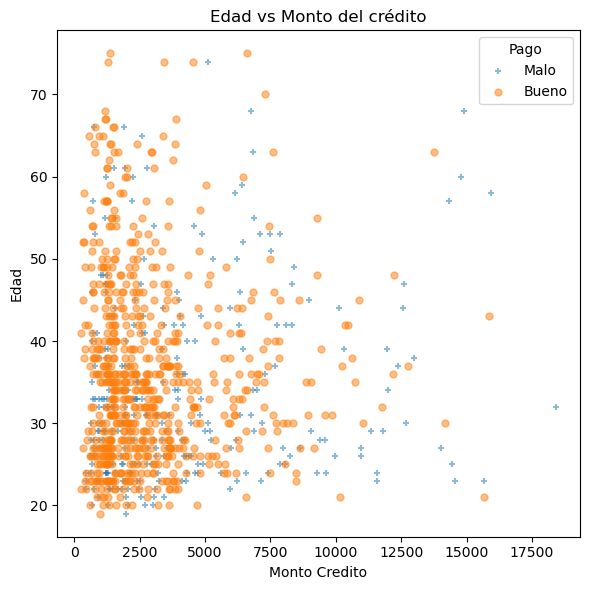

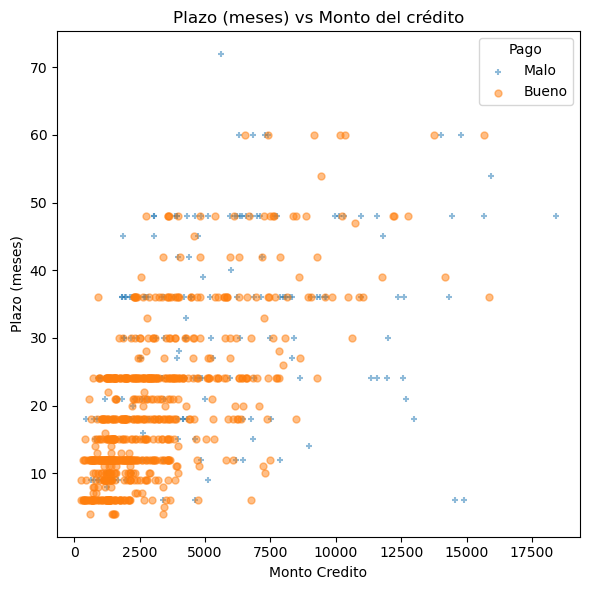

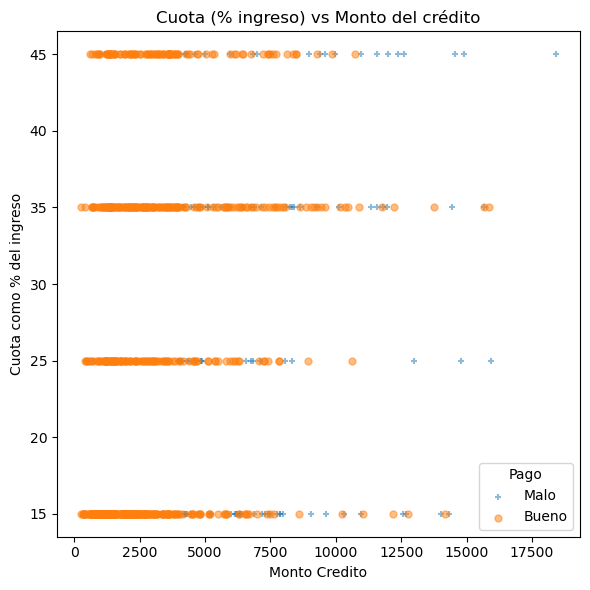

In [31]:
import numpy as np
import matplotlib.pyplot as plt

# --- 1) Columnas candidatas para ejes (muchos valores distintos, numéricas) ---
num_cols = [c for c in df.columns if np.issubdtype(df[c].dtype, np.number)]
cont_candidatas = [c for c in num_cols if c != "pago" and df[c].nunique() > 10]

print("Continuas candidatas para ejes:", cont_candidatas)
print("\nDistribución de la etiqueta 'pago':\n", df["pago"].value_counts().sort_index())

# --- 2) (Opcional) Aproximación de 'Income' usando 'tasa_cuota' (ordinal -> %) ---
# Nota: ajusta los valores si tu diccionario real difiere.
mapeo_rate_pct = {1: 45, 2: 35, 3: 25, 4: 15, 5: 10}
if "tasa_cuota" in df.columns and df["tasa_cuota"].nunique() <= 5:
    df["tasa_cuota_pct"] = df["tasa_cuota"].map(mapeo_rate_pct)
    if df["tasa_cuota_pct"].isna().any():
        # relleno conservador en caso de códigos no mapeados
        df["tasa_cuota_pct"] = df["tasa_cuota_pct"].fillna(df["tasa_cuota_pct"].median())
else:
    df["tasa_cuota_pct"] = np.nan  # no disponible

# --- 3) Función de gráfico estilo ISLR (Balance vs Income) ---
def scatter_credit(df, x="monto_credito", y="edad",
                   titulo=None, xlab=None, ylab=None, alpha=0.5):
    fig, ax = plt.subplots(figsize=(6,6))
    for clase, grp in df.groupby("pago"):
        # Asumimos 1=“bueno”, 0=“malo” (ajusta si tu codificación difiere)
        marker = "o" if clase == 1 else "+"
        label = "Bueno" if clase == 1 else "Malo"
        ax.scatter(grp[x], grp[y], marker=marker, alpha=alpha, s=25, label=label)
    ax.set_xlabel(xlab or x.replace("_", " ").title())
    ax.set_ylabel(ylab or y.replace("_", " ").title())
    ax.legend(title="Pago")
    ax.set_title(titulo or f"{(ylab or y)} vs {(xlab or x)}")
    plt.tight_layout()
    plt.show()

# --- 4) Tres gráficos recomendados ---
# (a) Monto (≈Balance) vs Edad (proxy continuo útil)
scatter_credit(df,
               x="monto_credito", y="edad",
               titulo="Edad vs Monto del crédito")

# (b) Monto vs Plazo (otra combinación informativa)
scatter_credit(df,
               x="monto_credito", y="plazo_meses",
               titulo="Plazo (meses) vs Monto del crédito",
               ylab="Plazo (meses)")

# (c) Monto vs % de cuota sobre ingreso (proxy de ingreso; valores altos ~ menor ingreso disponible)
if df["tasa_cuota_pct"].notna().any():
    scatter_credit(df,
                   x="monto_credito", y="tasa_cuota_pct",
                   titulo="Cuota (% ingreso) vs Monto del crédito",
                   ylab="Cuota como % del ingreso")
else:
    print("No se generó (c): 'tasa_cuota' no disponible o no mapeable en este archivo.")


Top parejas por AUC:
estado_cuenta vs plazo_meses: AUC=0.748
estado_cuenta vs historia_crediticia: AUC=0.743
estado_cuenta vs patrimonio: AUC=0.733


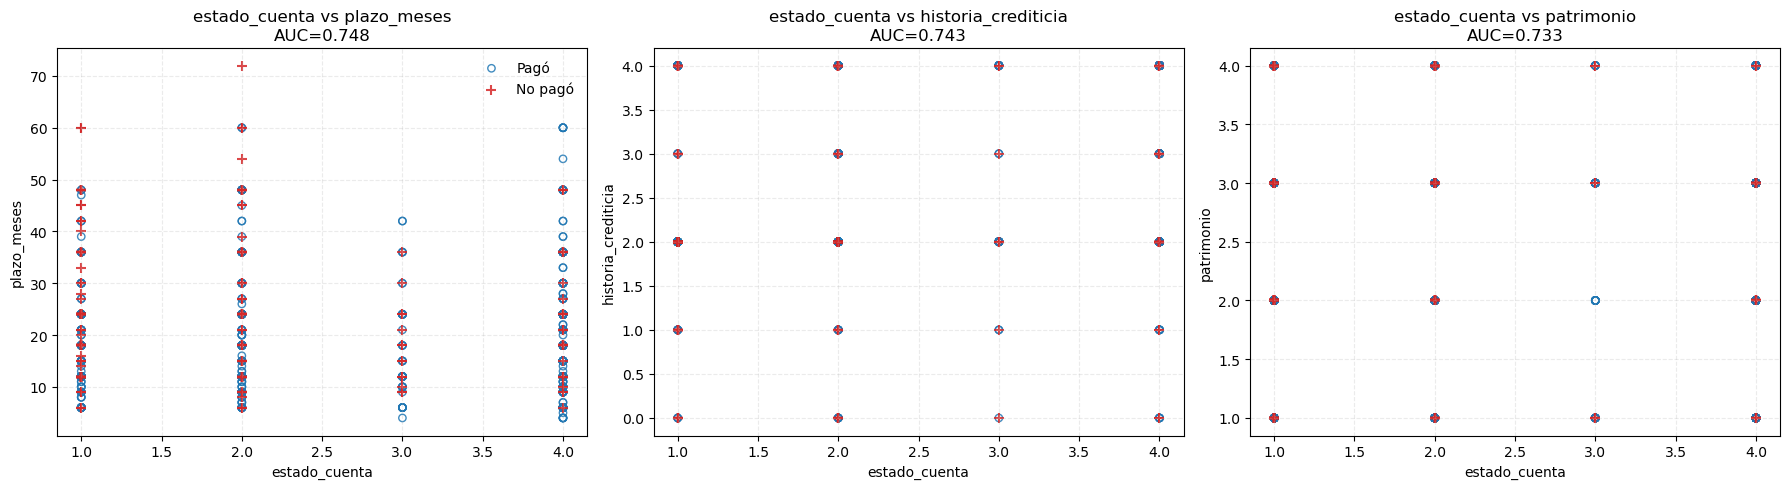

In [22]:
# Selección automática de parejas con mayor AUC y gráficos 'o' vs '+'
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

assert 'pago' in df.columns, "No se encontró la columna 'pago'. Ejecuta las celdas de carga."

# y: 1 si Pagó, 0 si No pagó
y = (df['pago'].astype(int) == 1).astype(int).values

# Tomar únicamente columnas numéricas distintas a 'pago'
numeric_cols = [c for c in df.select_dtypes(include=[np.number]).columns if c != 'pago']

pairs_auc = []
for a, b in itertools.combinations(numeric_cols, 2):
    sub = df[[a, b, 'pago']].dropna()
    if sub[a].nunique() < 2 or sub[b].nunique() < 2:
        continue
    y_sub = (sub['pago'].astype(int) == 1).astype(int).values
    X_sub = sub[[a, b]].values
    # Estandarizar para estabilidad numérica
    Xs = StandardScaler().fit_transform(X_sub)
    try:
        model = LogisticRegression(solver='liblinear', max_iter=1000)
        prob = model.fit(Xs, y_sub).predict_proba(Xs)[:, 1]
        auc = roc_auc_score(y_sub, prob)
        pairs_auc.append((auc, a, b))
    except Exception:
        continue

# Top 3 parejas por AUC
pairs_auc.sort(reverse=True, key=lambda x: x[0])
top_pairs = pairs_auc[:3]
print('Top parejas por AUC:')
for auc, a, b in top_pairs:
    print(f"{a} vs {b}: AUC={auc:.3f}")

# Graficar
n = len(top_pairs)
if n == 0:
    raise RuntimeError('No se pudo calcular AUC para ninguna pareja.')

fig, axes = plt.subplots(1, n, figsize=(6*n, 5), squeeze=False)
axes = axes[0]
mask_pago = df['pago'].astype(int) == 1

for i, (auc, a, b) in enumerate(top_pairs):
    ax = axes[i]
    m = df[[a, b]].notna().all(axis=1)
    mp = mask_pago & m
    mnp = (~mask_pago) & m
    ax.scatter(df.loc[mp, a], df.loc[mp, b], marker='o', facecolors='none', edgecolors='#1f77b4', s=28, alpha=0.85, label='Pagó')
    ax.scatter(df.loc[mnp, a], df.loc[mnp, b], marker='+', c='#d62728', s=50, alpha=0.85, label='No pagó')
    ax.set_xlabel(a)
    ax.set_ylabel(b)
    ax.set_title(f"{a} vs {b}\nAUC={auc:.3f}")
    ax.grid(alpha=0.25, linestyle='--')
    if i == 0:
        ax.legend(frameon=False)

plt.tight_layout()
plt.show()
